The purpose of this notebook is to demonstrate the methods in `methods/mp` and `methods/thomson` for computing nuclear wavefunctions and Franck-Condon factors for diatomic molecules.

In [1]:
import nepc.methods.mp as mp
import nepc.methods.thomson as thomson
from nepc.util.util import get_size
from nepc.util.constants import N2_DIATOMIC_CONSTANTS
from nepc.util.constants import MU_NITROGEN_KG
from nepc.util.constants import WAVENUMBER_PER_EV as WAVENUMBER_PER_EV
from nepc.util import scraper
from nepc.util import config
import pdfplumber
import numpy as np
import matplotlib.pyplot as plt
from nepc.util import latexify
from numpy import exp

## Reference Franck-Condon Factors

As validation of our computational method, we will compare with available Franck-Condon factors from the literature.

In [2]:
nepcHome = config.nepc_home()
pdfHome = nepcHome + "/ref/angus/"
tmpdir = nepcHome + "/tmp/"

In [3]:
pdfGilmore = scraper.get_pdf(pdfHome + "30_gilmore_j_phys_chem_ref_data_21_1005_1992.pdf")

In [4]:
scraper.rmdir(tmpdir)
scraper.mkdir(tmpdir)

In [5]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [6]:
def fcf_extracted_gilmore(pdf, page_number, x_0, column_width, y_0, y_1, vpp_max, locate_tables, debug):
    crop_dim = []
    for i in range(vpp_max + 1):
        crop_dim.append([x_0+i*column_width, y_0, x_0+(i+1)*column_width, y_1])
    fcf_data = []
    for i in range(len(crop_dim)):
        if debug is True: 
            print("vpp: ", str(i))
        dataY = scraper.get_column_strings(pdf=pdfGilmore,
                                           page_number=page_number,
                                           crop_dim_array=crop_dim[i],
                                           locate_tables=locate_tables)
        if locate_tables is False:
            dataY=[s.replace('(', 'E') for s in dataY]
            dataY=[s.replace(')', '') for s in dataY]
            dataY=[s.replace('{', 'E') for s in dataY]
            dataY=[s.replace('}', '') for s in dataY]
            dataY=[s.replace('t', '') for s in dataY]
            dataY=[s.replace(',', '.') for s in dataY]
            dataY=[s.replace("'", '') for s in dataY]
            dataY=[s.replace(' ', '') for s in dataY]
            dataY=[s.replace('*', '') for s in dataY]
            dataY=[s.replace(':', '.') for s in dataY]
            dataY=[s.replace('~', '4') for s in dataY]
            dataY=[s.replace('E-4.', 'E-4') for s in dataY]
            dataY=[s.replace('.5.50E-2', '5.50E-2') for s in dataY]
            dataY=[s.replace('<1E', '4E') for s in dataY]
            dataY=[s.replace('<lE', '4E') for s in dataY]
            dataY=[s.replace('!E', '7E') for s in dataY]
            dataY=[s.replace('E1E', '0E') for s in dataY]
            dataY=[s.replace('8EE', '85E') for s in dataY]
            dataY=[s.replace('OE-I', '0E-1') for s in dataY]
            dataY=[s.replace('SE', '8E') for s in dataY]
            dataY=[s.replace(']E', '1E') for s in dataY]
            dataY=[s.replace('].42E-2', '1.42E-2') for s in dataY]
            dataY=[s.replace('UJ3E-I', '1.03E-1') for s in dataY]            
            dataY=scraper.text_array_to_float_array(dataY)
            fcf_data.append(flatten(dataY))
    if locate_tables is False:
        return fcf_data


In [7]:
"""data_fcf_n2_table_XX stores the FCF's from Gilmore, Table XX"""
data_fcf_n2_table_20 = fcf_extracted_gilmore(pdf=pdfGilmore,
                                                  page_number=86,
                                                  x_0=163,
                                                  column_width=47,
                                                  y_0=170,
                                                  y_1=490,
                                                  vpp_max=10,
                                                  locate_tables=False,
                                                  debug=False)

In [8]:
#TODO: scrape remaining Franck-Condon factors for N2 and O2 for comparison

In [9]:
"""data_fcf_n2_table_XX stores the FCF's from Gilmore, Table XX"""
data_fcf_n2_table_28 = fcf_extracted_gilmore(pdf=pdfGilmore,
                                                  page_number=92,
                                                  x_0=163,
                                                  column_width=47,
                                                  y_0=170,
                                                  y_1=490,
                                                  vpp_max=10,
                                                  locate_tables=False,
                                                  debug=False)

In [10]:
data_fcf_n2_table_29 = fcf_extracted_gilmore(pdf=pdfGilmore,
                                                 page_number=93,
                                                 x_0=170,
                                                 column_width=47,
                                                  y_0=140,
                                                  y_1=450,
                                                 vpp_max=10,
                                                 locate_tables=False,
                                                 debug=False)

In [11]:
data_fcf_n2_table_30 = fcf_extracted_gilmore(pdf=pdfGilmore,
                                                 page_number=94,
                                                 x_0=175,
                                                 column_width=47,
                                                  y_0=170,
                                                  y_1=350,
                                                 vpp_max=10,
                                                 locate_tables=False,
                                                 debug=False)

In [12]:
data_fcf_n2_table_31 = fcf_extracted_gilmore(pdf=pdfGilmore,
                                                 page_number=95,
                                                 x_0=177,
                                                 column_width=47,
                                                  y_0=160,
                                                  y_1=330,
                                                 vpp_max=10,
                                                 locate_tables=False,
                                                 debug=False)

## Compute Overlap Integrals

As a validation, we can use the FCF code to compute overlap integrals for each state and check to make sure the diagonal elements are one and off-diagonal elements are zero.

In [13]:
#TODO: add remaining constants from NIST website to `nepc/util/constants.py`
#TODO: compute overlap integrals for all states and perform numerical checks below
N2_DIATOMIC_CONSTANTS.keys()

dict_keys(['N2(X1Sigmag+)', 'N2(A3Sigmau+)', 'N2(B3Pig)', 'N2+(X2Sigmag+)'])

In [14]:
p_list=['N2(X1Sigmag+)']
pp_list=['N2(X1Sigmag+)']
vp_list = np.arange(11)
vpp_list = np.arange(11)
jp_list = np.arange(1)
jpp_list = np.arange(1)
psi_p_keep = [p_list,[0,5,10],[0]]
psi_pp_keep = [pp_list,[0,5,10],[0]]
dbug = False

In [15]:
Vr_p, Vr_pp, psi_p, psi_pp, fcf = thomson.fcf(p_list, pp_list,
                                             vp_list, vpp_list,
                                             jp_list, jpp_list,
                                             diatomic_constants=N2_DIATOMIC_CONSTANTS,
                                             reduced_mass=MU_NITROGEN_KG,
                                             k=17,
                                             delta_r=.5,
                                             psi_p_keep=psi_p_keep,
                                             psi_pp_keep=psi_pp_keep,
                                             dbug=False)

In [16]:
get_size(fcf)

6560

In [17]:
get_size(psi_p)

4196070

In [18]:
get_size(psi_pp)

4196070

In [19]:
psi_p

[{'state': 'N2(X1Sigmag+)',
  'v': 0,
  'j': 0,
  'r_array': array([0.597688  , 0.59769802, 0.59770804, ..., 1.59766796, 1.59767798,
         1.597688  ]),
  'psi_r': array([7.42665204e-49, 7.46925834e-49, 7.51210701e-49, ...,
         1.65855649e-19, 1.65611356e-19, 1.65367418e-19])},
 {'state': 'N2(X1Sigmag+)',
  'v': 5,
  'j': 0,
  'r_array': array([0.597688  , 0.59769802, 0.59770804, ..., 1.59766796, 1.59767798,
         1.597688  ]),
  'psi_r': array([-3.99022991e-45, -4.01293903e-45, -4.03577628e-45, ...,
          4.59658249e-13,  4.59067380e-13,  4.58477256e-13])},
 {'state': 'N2(X1Sigmag+)',
  'v': 10,
  'j': 0,
  'r_array': array([0.597688  , 0.59769802, 0.59770804, ..., 1.59766796, 1.59767798,
         1.597688  ]),
  'psi_r': array([1.36169216e-42, 1.36938338e-42, 1.37711766e-42, ...,
         2.99332482e-08, 2.99008392e-08, 2.98684643e-08])}]

In [20]:
psi_pp

[{'state': 'N2(X1Sigmag+)',
  'v': 0,
  'j': 0,
  'r_array': array([0.597688  , 0.59769802, 0.59770804, ..., 1.59766796, 1.59767798,
         1.597688  ]),
  'psi_r': array([7.42665204e-49, 7.46925834e-49, 7.51210701e-49, ...,
         1.65855649e-19, 1.65611356e-19, 1.65367418e-19])},
 {'state': 'N2(X1Sigmag+)',
  'v': 5,
  'j': 0,
  'r_array': array([0.597688  , 0.59769802, 0.59770804, ..., 1.59766796, 1.59767798,
         1.597688  ]),
  'psi_r': array([-3.99022991e-45, -4.01293903e-45, -4.03577628e-45, ...,
          4.59658249e-13,  4.59067380e-13,  4.58477256e-13])},
 {'state': 'N2(X1Sigmag+)',
  'v': 10,
  'j': 0,
  'r_array': array([0.597688  , 0.59769802, 0.59770804, ..., 1.59766796, 1.59767798,
         1.597688  ]),
  'psi_r': array([1.36169216e-42, 1.36938338e-42, 1.37711766e-42, ...,
         2.99332482e-08, 2.99008392e-08, 2.98684643e-08])}]

In [21]:
print(np.diagonal(fcf[0][0][0][0]))

[1.         1.         1.         1.         1.         1.
 1.         0.99999999 1.00000012 0.99999932 0.99999882]


In [22]:
thomson.off_diagonal_elements(np.array(fcf[0][0][0][0]))

array([2.07452234e-25, 1.24617320e-23, 4.83189038e-26, 3.45089508e-21,
       1.32631304e-22, 8.54575853e-25, 1.67373587e-19, 6.85433272e-23,
       1.26223688e-22, 8.60654192e-24, 5.39873706e-17, 4.92852339e-18,
       8.79879354e-20, 7.48231527e-22, 5.51902721e-22, 5.73057701e-15,
       1.92864730e-16, 6.58201384e-19, 2.15819236e-19, 5.00807396e-20,
       8.26530160e-20, 2.03054601e-14, 6.67223439e-17, 5.29036709e-18,
       2.23894662e-17, 6.31765507e-19, 2.27550443e-17, 1.26641520e-17,
       1.20381575e-12, 3.34485714e-13, 2.90178417e-14, 1.28692739e-18,
       4.49942221e-16, 4.26981955e-16, 1.26431488e-15, 1.08492853e-16,
       3.41011670e-10, 6.38205896e-11, 3.97298855e-12, 7.13791033e-14,
       4.82641236e-14, 1.10737371e-14, 4.47552058e-14, 1.19177788e-15,
       2.66374997e-14, 4.42951852e-08, 1.05653446e-08, 9.97885410e-10,
       4.28179091e-11, 4.32263088e-12, 3.20062464e-13, 1.30608942e-12,
       6.87958423e-14, 1.05754903e-12, 1.06460967e-12, 2.07452234e-25,
      

In [23]:
thomson.rmse_off_diagonal_elements(np.array(fcf[0][0][0][0]))

6.141968809344218e-09

### Incremental RMSE

We can compute the RMSE as a function of v' to see how the cumulative error grows as we increase the number of vibrational levels.

In [24]:
thomson.incremental_rmse_off_diagonal_elements(np.array(fcf[0][0][0][0]))

i: 2; rmse: 2.074522339725268e-25
i: 3; rmse: 7.195835259280646e-24
i: 4; rmse: 1.4098713900934806e-21
i: 5; rmse: 5.293946037032414e-20
i: 6; rmse: 1.3997529058531574e-17
i: 7; rmse: 1.2512783765787558e-15
i: 8; rmse: 3.9874670519521434e-15
i: 9; rmse: 2.0832281798712301e-13
i: 10; rmse: 5.172134397905407e-11
i: 11; rmse: 6.141968809344218e-09


In [25]:
thomson.incremental_rmse_diagonal_elements(np.array(fcf[0][0][0][0]))

i: 1; rmse: 1.2434497875801753e-14
i: 2; rmse: 5.844456963317449e-14
i: 3; rmse: 8.705960933385516e-14
i: 4; rmse: 1.3228087202133447e-13
i: 5; rmse: 8.627418902497996e-12
i: 6; rmse: 2.070143500535053e-11
i: 7; rmse: 7.328131216053268e-10
i: 8; rmse: 2.783541706933249e-09
i: 9; rmse: 4.101190684672122e-08
i: 10; rmse: 2.1820593021132868e-07
i: 11; rmse: 4.115975731347987e-07


In [26]:
np.diagonal(np.array(fcf[0][0][0][0]))-1

array([-1.24344979e-14,  8.17124146e-14, -1.26121336e-13, -2.17381668e-13,
       -1.92896810e-11,  4.68949324e-11, -1.93817806e-09, -7.63057861e-09,
        1.22783564e-07, -6.78970170e-07, -1.17787941e-06])

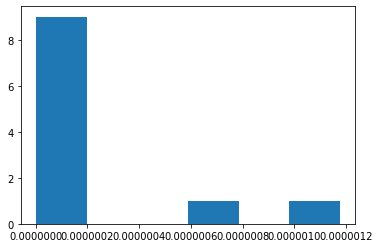

In [27]:
fcf_diagonal_error = np.sqrt((np.diagonal(np.array(fcf[0][0][0][0]))-1)**2)
# histogram on linear scale
#plt.subplot(311)
hist, bins, _ = plt.hist(fcf_diagonal_error, bins=6)

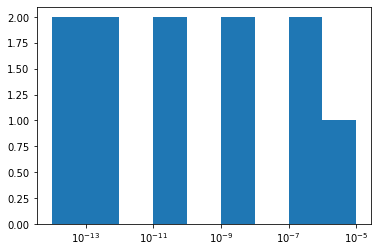

In [28]:
# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
bin_first = round(np.log10(bins[0]))
bin_last = round(np.log10(bins[-1])+1)
logbins = np.logspace(bin_first, bin_last, abs(bin_first) - abs(bin_last)+1)
#plt.subplot(312)
plt.hist(fcf_diagonal_error, bins=logbins)
plt.xscale('log')
plt.show()

### Check of delta_r

We can visually inspect plots of psi_p, psi_pp, and psi_p x psi_pp for the highest vibrational modes to ensure that we have captured the entire wavefunction (but haven't made the integration limits too large).

In [29]:
psi_0 = psi_p[1]['psi_r']
r_array_0 = psi_p[1]['r_array']
psi_1 = psi_p[2]['psi_r']
r_array_1 = psi_p[2]['r_array']
psi_0_1 = psi_0 * psi_1

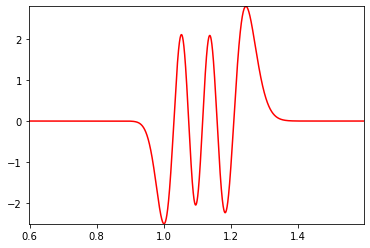

In [30]:
plt.plot(r_array_0,psi_0, 'r')
plt.axis([min(r_array_0), max(r_array_0), min(psi_0), max(psi_0)])
plt.show()

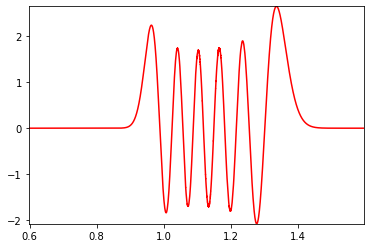

In [31]:
plt.plot(r_array_1, psi_1, 'r')
plt.axis([min(r_array_1), max(r_array_1), min(psi_1), max(psi_1)])
plt.show()

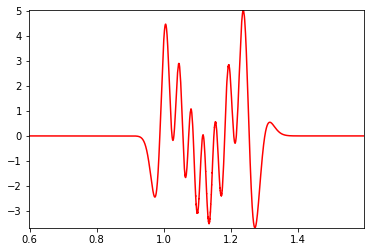

In [32]:
plt.plot(r_array_0, psi_0_1, 'r')
plt.axis([min(r_array_0), max(r_array_0), min(psi_0_1), max(psi_0_1)])
plt.show()

## FCFs

Now, we compute FCFs for the case where p' and p'' differ, compare with Gilmore's results, and also look at closure relationships.

In [33]:
N2_DIATOMIC_CONSTANTS.keys()

dict_keys(['N2(X1Sigmag+)', 'N2(A3Sigmau+)', 'N2(B3Pig)', 'N2+(X2Sigmag+)'])

In [34]:
p_list=['N2(X1Sigmag+)']
pp_list=['N2(B3Pig)']
vp_list = np.arange(11)
vpp_list = np.arange(11)
jp_list = np.arange(1)
jpp_list = np.arange(1)
psi_p_keep = [p_list,[0,5,10],[0]]
psi_pp_keep = [pp_list,[0,5,10],[0]]
dbug = False

In [35]:
Vr_p, Vr_pp, psi_p, psi_pp, fcf = thomson.fcf(p_list, pp_list,
                                 vp_list, vpp_list,
                                 jp_list, jpp_list,
                                 diatomic_constants=N2_DIATOMIC_CONSTANTS,
                                 reduced_mass=MU_NITROGEN_KG,
                                 k=17,
                                 delta_r=.5,
                                 psi_p_keep=psi_p_keep,
                                 psi_pp_keep=psi_pp_keep,
                                 dbug=False)

In [36]:
for i in range(len(fcf[0][0][0][0])):
    print('\nv\'/v\'\': {}'.format(i))
    for j in range(len(fcf[0][0][0][0][0])):
        print('{}\t{:.2E}\t{:.2E}'.format(j, data_fcf_n2_table_20[i][j], fcf[0][0][0][0][i][j]))



v'/v'': 0
0	6.11E-02	4.21E-02
1	1.47E-01	1.08E-01
2	1.95E-01	1.56E-01
3	1.90E-01	1.68E-01
4	1.51E-01	1.51E-01
5	1.05E-01	1.20E-01
6	6.65E-02	8.81E-02
7	3.90E-02	6.06E-02
8	2.16E-02	3.99E-02
9	1.15E-02	2.54E-02
10	5.92E-03	1.58E-02

v'/v'': 1
0	1.91E-01	1.58E-01
1	1.93E-01	1.93E-01
2	6.54E-02	1.00E-01
3	7.17E-04	1.79E-02
4	2.58E-02	1.51E-03
5	7.60E-02	2.81E-02
6	1.04E-01	6.07E-02
7	1.03E-01	7.95E-02
8	8.39E-02	8.18E-02
9	6.04E-02	7.29E-02
10	3.98E-02	5.92E-02

v'/v'': 2
0	2.74E-01	2.64E-01
1	4.50E-02	7.74E-02
2	2.39E-02	3.03E-03
3	1.05E-01	6.86E-02
4	8.38E-02	9.33E-02
5	2.07E-02	5.52E-02
6	5.33E-04	1.29E-02
7	2.49E-02	1.16E-04
8	5.85E-02	1.27E-02
9	7.72E-02	3.36E-02
10	7.73E-02	4.99E-02

v'/v'': 3
0	2.41E-01	2.60E-01
1	1.59E-02	2.52E-03
2	1.30E-01	1.13E-01
3	3.60E-02	6.92E-02
4	7.32E-03	1.52E-03
5	6.56E-02	2.44E-02
6	7.50E-02	6.24E-02
7	3.34E-02	6.01E-02
8	2.39E-03	3.13E-02
9	6.14E-03	6.72E-03
10	3.00E-02	1.62E-04

v'/v'': 4
0	1.44E-01	1.68E-01
1	1.42E-01	1.16E-01
2	4.81E-02	7.81E-02
3

These calculated FCF's appear to be fairly close to Gilmore's results, especially for v', v'' < 5.

In [37]:
thomson.rmse_calc_ref(np.array(fcf[0][0][0][0]), data_fcf_n2_table_20)

0.022055007530572136

In [38]:
p_list=['N2(X1Sigmag+)']
pp_list=['N2+(X2Sigmag+)']
vp_list = np.arange(11)
vpp_list = np.arange(11)
jp_list = np.arange(1)
jpp_list = np.arange(1)
psi_p_keep = [p_list,[0,5,10],[0]]
psi_pp_keep = [pp_list,[0,5,10],[0]]
dbug = False

In [39]:
Vr_p, Vr_pp, psi_p, psi_pp, fcf = thomson.fcf(p_list, pp_list,
                                 vp_list, vpp_list,
                                 jp_list, jpp_list,
                                 diatomic_constants=N2_DIATOMIC_CONSTANTS,
                                 reduced_mass=MU_NITROGEN_KG,
                                 k=17,
                                 delta_r=.5,
                                 psi_p_keep=psi_p_keep,
                                 psi_pp_keep=psi_pp_keep,
                                 dbug=False)

In [40]:
psi_p[0]

{'state': 'N2(X1Sigmag+)',
 'v': 0,
 'j': 0,
 'r_array': array([0.6070505 , 0.60706052, 0.60707054, ..., 1.60703046, 1.60704048,
        1.6070505 ]),
 'psi_r': array([1.42448247e-46, 1.43237972e-46, 1.44032037e-46, ...,
        4.15697365e-20, 4.15079662e-20, 4.14462864e-20])}

In [41]:
psi_pp[0]

{'state': 'N2+(X2Sigmag+)',
 'v': 0,
 'j': 0,
 'r_array': array([0.6070505 , 0.60706052, 0.60707054, ..., 1.60703046, 1.60704048,
        1.6070505 ]),
 'psi_r': array([1.42570893e-44, 1.43304035e-44, 1.44040912e-44, ...,
        1.38192146e-16, 1.38015175e-16, 1.37838428e-16])}

In [42]:
thomson.print_fcf_calc_ref(fcf[0][0][0][0], data_fcf_n2_table_28)


v'/v'': 0
0	9.17E-01	9.11E-01
1	7.79E-02	8.58E-02
2	4.65E-03	3.09E-03
3	2.68E-04	1.22E-05
4	1.76E-05	6.41E-06
5	1.55E-06	2.16E-06
6	2.13E-07	2.58E-07
7	4.74E-08	1.57E-08
8	1.47E-08	3.23E-10
9	5.49E-09	1.97E-10
10	2.24E-09	2.79E-11

v'/v'': 1
0	8.02E-02	8.31E-02
1	7.60E-01	7.42E-01
2	1.45E-01	1.64E-01
3	1.38E-02	1.03E-02
4	1.12E-03	1.06E-04
5	9.62E-05	2.11E-05
6	1.06E-05	1.16E-05
7	1.71E-06	1.87E-06
8	4.21E-07	1.54E-07
9	1.42E-07	5.55E-09
10	5.67E-08	6.68E-11

v'/v'': 2
0	2.53E-03	5.60E-03
1	1.54E-01	1.55E-01
2	6.12E-01	5.85E-01
3	2.01E-01	2.32E-01
4	2.72E-02	2.24E-02
5	2.89E-03	4.55E-04
6	3.14E-04	3.59E-05
7	4.18E-05	3.52E-05
8	7.79E-06	7.52E-06
9	2.11E-06	8.15E-07
10	7.58E-07	3.89E-08

v'/v'': 3
0	4.47E-05	1.81E-04
1	7.91E-03	1.67E-02
2	2.21E-01	2.13E-01
3	4.75E-01	4.42E-01
4	2.44E-01	2.87E-01
5	4.45E-02	3.98E-02
6	6.00E-03	1.37E-03
7	7.97E-04	3.66E-05
8	1.25E-04	7.83E-05
9	2.65E-05	2.21E-05
10	7.79E-06	3.11E-06

v'/v'': 4
0	4.17E-07	5.01E-06
1	2.04E-04	7.57E-04
2	1.65E-02	3.29E-02
3

In [43]:
thomson.rmse_calc_ref(np.array(fcf[0][0][0][0]), data_fcf_n2_table_28)

0.0353717953634288

A check of the closure relationship.

#TODO: explain this; what does it mean exactly?

In [44]:
thomson.fcf_closure(fcf[0][0][0][0])

v'	closure_vp
0	1.0000000001760954
1	0.9999999998733775
2	0.9999999954671023
3	0.999999787964501
4	0.9999896990741304
5	0.9998664034723802
6	0.9994862756208629
7	0.9988741751701683
8	0.9646437261935991
9	0.7400274914905534
10	0.4591720619948812

v''	closure_vpp
0	1.0000000547396044
1	1.00000000153125
2	0.9999999999077138
3	0.9999999995939037
4	1.000000001448294
5	0.9999992411753469
6	0.9999555959265916
7	0.9974206965118471
8	0.9585597271597751
9	0.7226200463573238
10	0.4835042521460014


In [45]:
psi_0 = psi_p[2]['psi_r']
r_array_0 = psi_p[2]['r_array']
psi_1 = psi_pp[2]['psi_r']
r_array_1 = psi_pp[2]['r_array']
psi_0_1 = psi_0 * psi_1

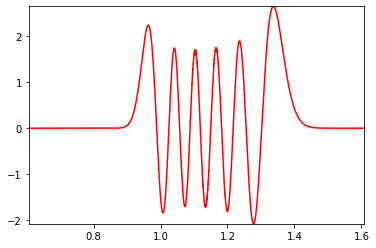

In [46]:
plt.plot(r_array_0,psi_0, 'r')
plt.axis([min(r_array_0), max(r_array_0), min(psi_0), max(psi_0)])
plt.show()

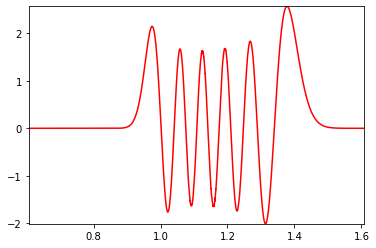

In [47]:
plt.plot(r_array_1, psi_1, 'r')
plt.axis([min(r_array_1), max(r_array_1), min(psi_1), max(psi_1)])
plt.show()

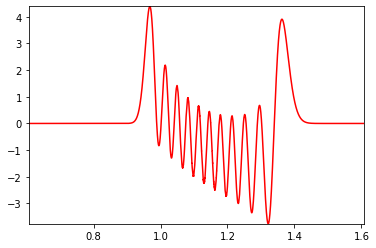

In [48]:
plt.plot(r_array_0, psi_0_1, 'r')
plt.axis([min(r_array_0), max(r_array_0), min(psi_0_1), max(psi_0_1)])
plt.show()

In [49]:
thomson.fcf_closure(fcf[0][0][0][0])

v'	closure_vp
0	1.0000000001760954
1	0.9999999998733775
2	0.9999999954671023
3	0.999999787964501
4	0.9999896990741304
5	0.9998664034723802
6	0.9994862756208629
7	0.9988741751701683
8	0.9646437261935991
9	0.7400274914905534
10	0.4591720619948812

v''	closure_vpp
0	1.0000000547396044
1	1.00000000153125
2	0.9999999999077138
3	0.9999999995939037
4	1.000000001448294
5	0.9999992411753469
6	0.9999555959265916
7	0.9974206965118471
8	0.9585597271597751
9	0.7226200463573238
10	0.4835042521460014


In [50]:
psi_p[0]

{'state': 'N2(X1Sigmag+)',
 'v': 0,
 'j': 0,
 'r_array': array([0.6070505 , 0.60706052, 0.60707054, ..., 1.60703046, 1.60704048,
        1.6070505 ]),
 'psi_r': array([1.42448247e-46, 1.43237972e-46, 1.44032037e-46, ...,
        4.15697365e-20, 4.15079662e-20, 4.14462864e-20])}

In [51]:
psi_pp[2]

{'state': 'N2+(X2Sigmag+)',
 'v': 10,
 'j': 0,
 'r_array': array([0.6070505 , 0.60706052, 0.60707054, ..., 1.60703046, 1.60704048,
        1.6070505 ]),
 'psi_r': array([1.51849115e-38, 1.52616979e-38, 1.53388687e-38, ...,
        6.05421872e-06, 6.04887839e-06, 6.04354260e-06])}

In [52]:
Vr_p

[{'To': 0.0,
  'we': 2358.57,
  'wexe': 14.324,
  're': 1.097688,
  'a': 2.6892329559209247,
  'De': 79890.0},
 {'To': 0.0,
  'we': 2358.57,
  'wexe': 14.324,
  're': 1.097688,
  'a': 2.6892329559209247,
  'De': 79890.0},
 {'To': 0.0,
  'we': 2358.57,
  'wexe': 14.324,
  're': 1.097688,
  'a': 2.6892329559209247,
  'De': 79890.0}]

In [53]:
def Vr_array(Vr_p, r_array):
    return ((mp.Te(Vr_p['To'], Vr_p['we'], Vr_p['wexe']) + 
             Vr_p['De']*(1.0 - exp(-Vr_p['a']*(r_array - Vr_p['re'])))**2 )/WAVENUMBER_PER_EV)

In [54]:
r_array_0 == r_array_1

array([ True,  True,  True, ...,  True,  True,  True])

In [55]:
#TODO: move this next block (and minimum amount of code required) to pubs_nepc

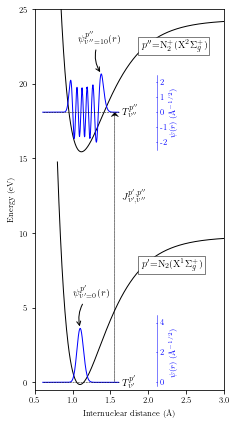

In [56]:
latexify.latexify(fig_height=6)

r_array = (.8 + np.arange(441)*.005)

ip=0
ipp=2

Vr_p_array = Vr_array(Vr_p[ip], r_array)
Vr_pp_array = Vr_array(Vr_pp[ipp], r_array)

Tv_0 = mp.Tv(psi_p[ip]['v'], Vr_p[ip]['To'], Vr_p[ip]['we'], Vr_p[ip]['wexe'])/WAVENUMBER_PER_EV
Tv_1 = mp.Tv(psi_pp[ipp]['v'], Vr_pp[ipp]['To'], Vr_pp[ipp]['we'], Vr_pp[ipp]['wexe'])/WAVENUMBER_PER_EV

psi_0 = Tv_0 + psi_p[ip]['psi_r']
r_array_0 = psi_p[ip]['r_array']
psi_1 = Tv_1 + psi_pp[ipp]['psi_r']
r_array_1 = psi_pp[ipp]['r_array']

#psi_0_1 = 25 + psi_p[ip]['psi_r'] * psi_pp[ipp]['psi_r']


fig,  ax1 = plt.subplots(1)

#ax1.set_xscale("log")
#ax1.set_yscale("log")
#ax1.set_adjustable("datalim")
ax1.plot(r_array, Vr_p_array, 'black',
         r_array, Vr_pp_array, 'black', 
         r_array_0, psi_0, 'b',
         r_array_1, psi_1, 'b', linewidth=1)
ax1.plot([r_array_0[0], r_array_0[-1]], [Tv_0,Tv_0], 'black', 
         [r_array_1[0], r_array_1[-1]], [Tv_1,Tv_1], 'black', ls='--', lw=.5)

ax1.set_xlim(.5, 3.0)
ax1.set_ylim(-0.5, 25)
ax1.set_ylabel('Energy (eV)')
ax1.set_xlabel('Internuclear distance (\AA)')
ax1.arrow(max(r_array_0)-0.05, Tv_0, 0, Tv_0+Tv_1, color='black', lw=.3, ls='--', 
          head_length=.3, head_width=.1, length_includes_head=True,
          overhang=.3)
x_offset = 0.05
y_offset = -.3
ax1.text(max(r_array_0) + x_offset, Tv_0 + (Tv_1-Tv_0)*(2/3), 
         r"$J_{v',v''}^{p',p''}$")
ax1.text(max(r_array_0) + x_offset, Tv_1 + y_offset, 
         r"$T_{v''}^{p''}$")
ax1.text(max(r_array_0) + x_offset, Tv_0 + y_offset, 
         r"$T_{v'}^{p'}$")


psi_p_i = np.argmax(psi_0)
psi_pp_i = np.argmax(psi_1)

x_psi_p = r_array_0[psi_p_i]
y_psi_p = psi_0[psi_p_i]
x_psi_pp = r_array_1[psi_pp_i]
y_psi_pp = psi_1[psi_pp_i]

ax1.annotate(r"$\psi_{v'=0}^{p'}(r)$",
             xy=(x_psi_p, y_psi_p), 
             xytext=(x_psi_p - .1, y_psi_p + 2),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.3"))
ax1.annotate(r"$\psi_{v''=10}^{p''}(r)$",
             xy=(x_psi_pp, y_psi_pp), 
             xytext=(x_psi_pp - .3, y_psi_pp + 2),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.3"))


r_index = int(len(r_array)*(.5))
ax1.text(r_array[r_index], Vr_p_array[r_index], r"$p'$=N$_2$(X${}^1\Sigma_g^+$)",
         bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3, 'lw': .5})
ax1.text(r_array[r_index], Vr_pp_array[r_index], r"$p''$=N$_2^+$(X${}^2\Sigma_g^+$)",
         bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3, 'lw': .5})

t_loc = max(r_array_0) + 10*x_offset
tw = .01

ax1.plot([t_loc, t_loc],
         [Tv_0 - .25, Tv_0 + 4.5], 'b', lw=.5)
ax1.text(t_loc + 15*tw, Tv_0+2, "$\psi(r)$ (\AA$^{-1/2}$)", 
         rotation=90, color='b', verticalalignment='center', fontsize=8)
ax1.plot([t_loc, t_loc],
         [Tv_1 - 2.5, Tv_1 + 2.5], 'b', lw=.5)
ax1.text(t_loc + 15*tw, Tv_1, "$\psi(r)$ (\AA$^{-1/2}$)", 
         rotation=90, color='b', verticalalignment='center', fontsize=8)


for psi_tick in [0, 2, 4]:
    ax1.plot([t_loc - tw, t_loc + tw],
             [Tv_0+psi_tick, Tv_0+psi_tick], 'b', lw=.5)
    ax1.text(t_loc + 5*tw, Tv_0+psi_tick, str(psi_tick), 
             verticalalignment='center', fontsize=8, color='b')
    
for psi_tick in [-2, -1, 0, 1, 2]:
    ax1.plot([t_loc - tw, t_loc + tw],
             [Tv_1+psi_tick, Tv_1+psi_tick], 'b', lw=.5)
    ax1.text(t_loc + 5*tw, Tv_1+psi_tick, str(psi_tick), 
             verticalalignment='center', fontsize=8, color='b')

    
#ax1.set_aspect(.5)
#ax1.set_title("N$_2$ ionization reduced cross section")

plt.tight_layout()

plt.draw()

# save to file
plt.savefig('fig/n2_potential_psi.pdf')
plt.savefig('fig/n2_potential_psi.eps')

plt.show()